In [232]:
import numpy as np
import skimage
import matplotlib.pyplot as plt
import skimage

from skimage.feature import hog
from skimage import data, exposure
from skimage.exposure import histogram
from skimage.feature import match_template
from skimage.transform import rescale
from skimage.util import random_noise
from scipy.signal import correlate2d
from skimage import io
from skimage.transform import resize

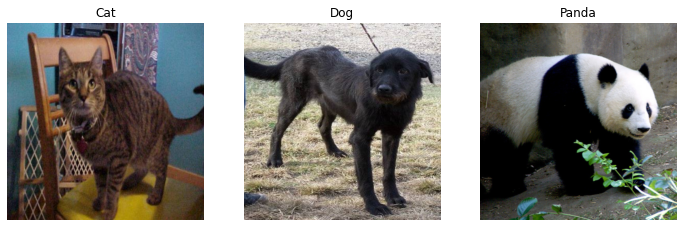

In [233]:
size = 1_000
pixel_per_cell = (8,8)

cats = [resize(io.imread(f"animals/cats/cats_0000{idx}.jpg"), (size, size)) for idx in range(1,10)]
dogs = [resize(io.imread(f"animals/dogs/dogs_0000{idx}.jpg"), (size, size)) for idx in range(1,10)]
pandas = [resize(io.imread(f"animals/pandas/panda_0000{idx}.jpg"), (size, size)) for idx in range(1,10)]
images = cats + dogs + pandas

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))
axes[0].imshow(cats[0]) and axes[0].axis('off') and axes[0].set_title("Cat")
axes[1].imshow(dogs[0]) and axes[1].axis('off') and axes[1].set_title("Dog")
axes[2].imshow(pandas[0]) and axes[2].axis('off') and axes[2].set_title("Panda")

plt.show()

In [234]:

cats_hog = [hog(img, orientations=8, pixels_per_cell= pixel_per_cell,
                    cells_per_block=(1, 1), channel_axis=2) for img in cats]
dogs_hog = [hog(img, orientations=8, pixels_per_cell=pixel_per_cell,
                    cells_per_block=(1, 1), channel_axis=2) for img in dogs]
pandas_hog = [hog(img, orientations=8, pixels_per_cell=pixel_per_cell,
                    cells_per_block=(1, 1), channel_axis=2) for img in pandas]

# étiquettes (1 pour les chats, 2 pour les chiens, 3 pour les panda)
cats_labels = 1 * np.ones((len(cats_hog), ))
dogs_labels = 2 * np.ones((len(dogs_hog), ))
pandas_labels = 3 * np.ones((len(pandas_hog), ))

dataset = np.concatenate((cats_hog, dogs_hog, pandas_hog))
labels = np.concatenate((cats_labels, dogs_labels, pandas_labels)).astype("int")
print(labels.shape)

(27,)


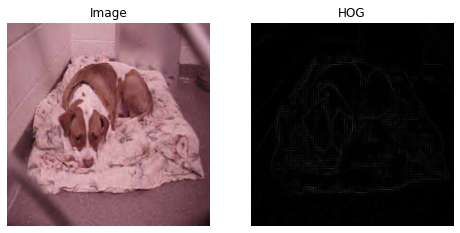

In [235]:
query = resize(io.imread("animals/dogs/dogs_00010.jpg"), (size, size))
image = resize(io.imread("animals/dogs/dogs_00010.jpg"), (size, size))

descriptor, hog_image = hog(image, orientations=8, pixels_per_cell=pixel_per_cell,
                    cells_per_block=(2, 1), visualize=True, channel_axis=2)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(image, cmap="gray") and ax1.set_title("Image")

# Amélioration du contraste
hog_image = exposure.rescale_intensity(hog_image, in_range=(0, 10))
ax2.axis('off')
ax2.imshow(hog_image, cmap="gray") and ax2.set_title("HOG")
plt.show()

[ 9 24 14 16 13 25  4 20 22 23  1 26  3  7  0 18 21 19 11 15 12  8  5 17
 10  6  2]
Étiquettes des 17 images les plus proches : [2 3 2 2 2 3 1 3 3 3 1 3 1 1 1 3 3]
Étiquette majoritaire : 3


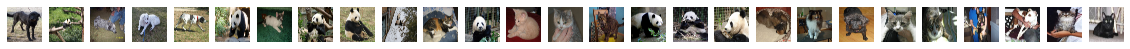

In [236]:
hog_query = hog(query, orientations=8, pixels_per_cell=pixel_per_cell,
                    cells_per_block=(1, 1), channel_axis=2)
scores = np.array([np.linalg.norm(hog_query - hog) for hog in dataset])

closest = np.argsort(scores)
print(closest)
fig, axes = plt.subplots(nrows=1, ncols=len(closest), figsize=(20, 8))
for idx, img_idx in enumerate(closest):
    axes[idx].imshow(images[img_idx]) and axes[idx].axis('off')

k = 17
closest_labels = labels[closest[:k]]
print(f"Étiquettes des {k} images les plus proches : {closest_labels}")
print(f"Étiquette majoritaire : {np.argmax(np.bincount(closest_labels))}")

Base de données :


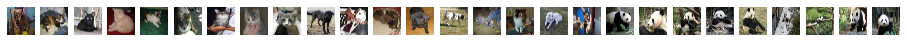

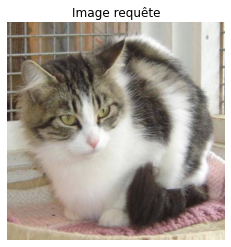

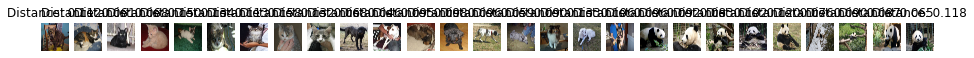

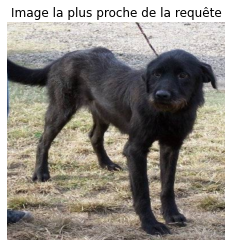

In [237]:
#database = [resize(io.imread(f"animals/cats/cats_0000{idx}.jpg"), (size, size)) for idx in range(1,10)]
print("Base de données :")
fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(16, 6))
for img, ax in zip(images, axes):
    ax.imshow(img) and ax.axis("off")
plt.show()

query = resize(io.imread(f"animals/cats/cats_00010.jpg"), (size, size))
plt.imshow(query) and plt.axis("off")
plt.title("Image requête")
plt.show()


def color_histogram(image):
    hists = [histogram(image[:,:,idx], normalize=True)[0][1:-1] for idx in range(3)]
    return np.concatenate(hists)
                       
db_hists = [color_histogram(img) for img in images]
query_hist = color_histogram(query)

scores = [np.linalg.norm(db_hist - query_hist) for db_hist in db_hists]

# on trouve l'image pour laquelle le score est le minimum
closest_idx = np.argmin(scores)

fig, axes = plt.subplots(nrows=1, ncols=len(images), figsize=(16, 6))
for img, ax, score in zip(images, axes, scores):
    ax.imshow(img)
    ax.set_title(f"Distance: {score:.3f}")
    ax.axis("off")
plt.show()

plt.imshow(images[closest_idx])
plt.title("Image la plus proche de la requête")
plt.axis("off")
plt.show()